# Classification Image Project : Garbage Classification
- **Nama:** Ade Safarudin Madani
- **Email:** adesfdnmdn@gmail.com
- **ID Dicoding:** ade_madani

## Objective:
Membangun model CNN yang dapat melakukan klasifikasi terhadap jenis-jenis sampah. Adapun jenis dari sampah pada dataset yang digunakan yakni dataset gambar (citra) yang terbagi menjadi 12 kelas dimulai dari battery , biological , brown-glass, cardboard, clothes, green-glass, metal, paper, plastic , shoes, trash dan white-glass.

## Dataset Source:
https://www.kaggle.com/datasets/mostafaabla/garbage-classification

## **0. Import Libraries**

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
# Mengimpor libraries umum yang sering digunakan
import os
import shutil
import random
from random import sample
import pathlib
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Mengimpor libraries untuk pemrosesan data gambar
from PIL import Image

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback, LearningRateScheduler

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
print(tf.__version__)

2.18.0


## **1. Data Preparation**

### **1.1 Data Loading**

In [4]:
!curl -L -o /content/garbage-classification.zip\
  https://www.kaggle.com/api/v1/datasets/download/mostafaabla/garbage-classification

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  239M  100  239M    0     0   120M      0  0:00:01  0:00:01 --:--:--  193M


In [5]:
!unzip /content/garbage-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: garbage_classification/paper/paper381.jpg  
  inflating: garbage_classification/paper/paper382.jpg  
  inflating: garbage_classification/paper/paper383.jpg  
  inflating: garbage_classification/paper/paper384.jpg  
  inflating: garbage_classification/paper/paper385.jpg  
  inflating: garbage_classification/paper/paper386.jpg  
  inflating: garbage_classification/paper/paper387.jpg  
  inflating: garbage_classification/paper/paper388.jpg  
  inflating: garbage_classification/paper/paper389.jpg  
  inflating: garbage_classification/paper/paper39.jpg  
  inflating: garbage_classification/paper/paper390.jpg  
  inflating: garbage_classification/paper/paper391.jpg  
  inflating: garbage_classification/paper/paper392.jpg  
  inflating: garbage_classification/paper/paper393.jpg  
  inflating: garbage_classification/paper/paper394.jpg  
  inflating: garbage_classification/paper/paper395.jpg  
  inflating: garbage_classification/pa

In [6]:
# check label name
folder_path = '/content/garbage_classification'
folder_names = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

folder_names_sorted = sorted(folder_names)

for folder in folder_names_sorted:
    print(folder)

total_label = len(folder_names_sorted)
print(f"Total label: {total_label}")

battery
biological
brown-glass
cardboard
clothes
green-glass
metal
paper
plastic
shoes
trash
white-glass
Total label: 12


In [7]:
# Path ke dataset
path = 'garbage_classification'

widths = []
heights = []

# Loop semua subfolder dan file
for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(root, filename)
            try:
                img = Image.open(img_path)
                width, height = img.size
                widths.append(width)
                heights.append(height)
            except:
                print(f"Error loading image: {img_path}")

# Hitung statistik
if widths and heights:
    print(f"Jumlah gambar: {len(widths)}")
    print(f"Lebar (Width) - Min: {np.min(widths)}, Max: {np.max(widths)}, Rata-rata: {np.mean(widths):.2f}")
    print(f"Tinggi (Height) - Min: {np.min(heights)}, Max: {np.max(heights):.2f}")
else:
    print("Tidak ada gambar ditemukan.")

Jumlah gambar: 15515
Lebar (Width) - Min: 51, Max: 888, Rata-rata: 349.82
Tinggi (Height) - Min: 100, Max: 936.00


**Note**:
- Ukuran dimensi data gambar dataset berbeda-beda sehingga nantinya perlu diseragamkan ukurannya karena model lebih mudah mempelajari fitur pada gambar.

### **1.2 Plot Every Class Image**

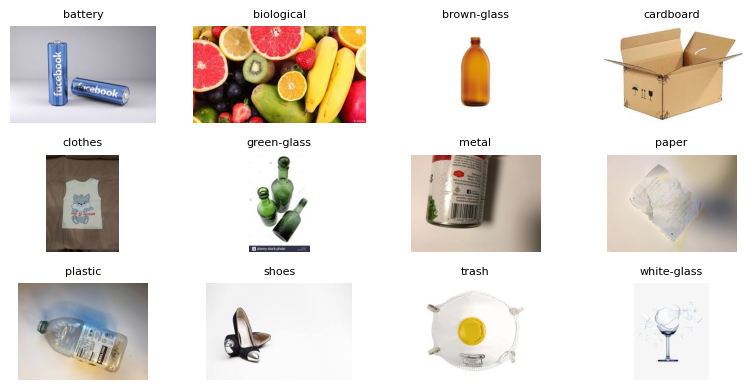

In [8]:
# Path ke dataset
path = 'garbage_classification'

# Ambil semua nama kelas
class_names = sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

# Buat kamus yang menyimpan daftar file gambar per kelas
class_images = {
    class_name: os.listdir(os.path.join(path, class_name))
    for class_name in class_names
}

# Tentukan ukuran grid
cols = 4
rows = int(np.ceil(len(class_names) / cols))

# Plot
fig, axs = plt.subplots(rows, cols, figsize=(8, 4))
axs = axs.flatten()

for idx, class_name in enumerate(class_names):
    image_list = class_images[class_name]
    if len(image_list) == 0:
        continue  # skip kelas yang kosong
    img_file = np.random.choice(image_list)
    img_path = os.path.join(path, class_name, img_file)

    try:
        img = Image.open(img_path).convert("RGB")
        axs[idx].imshow(img)
        axs[idx].set_title(class_name, fontsize=8)
        axs[idx].axis('off')
    except:
        axs[idx].axis('off')  # skip jika ada error buka gambar

# Kosongkan axis yang tidak terpakai
for i in range(len(class_names), len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.show()


### **1.3 Check Class Distribution**

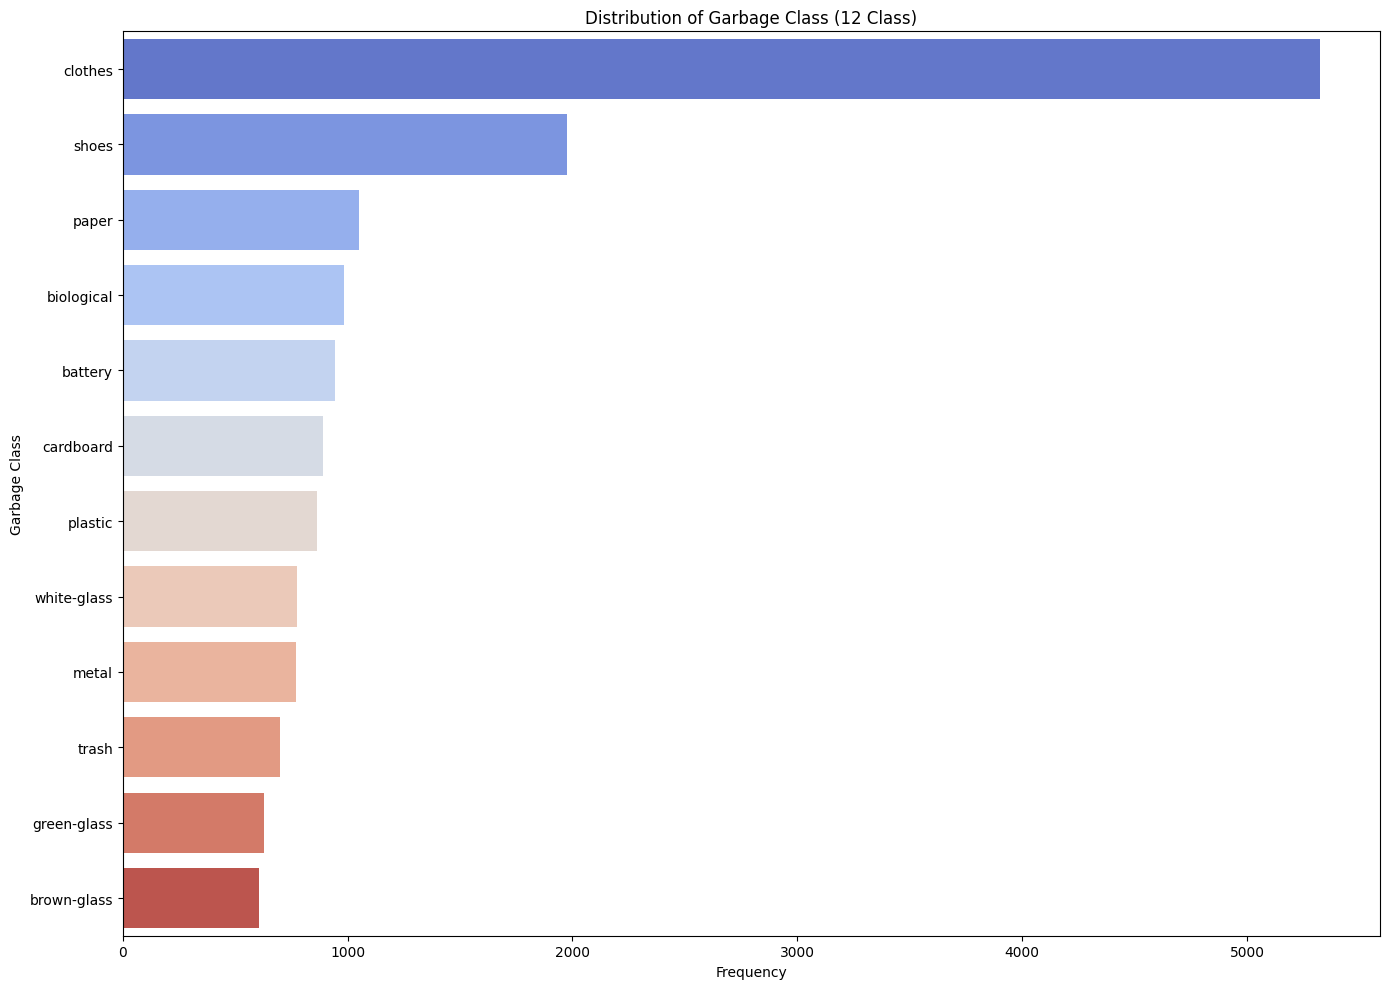

In [9]:
# Hitung jumlah gambar per kelas
class_counts = {}
for class_name in os.listdir(path):
    class_dir = os.path.join(path, class_name)
    if os.path.isdir(class_dir):
        count = len([
            file for file in os.listdir(class_dir)
            if file.lower().endswith(('.jpg'))
        ])
        class_counts[class_name] = count

# Sort berdasarkan jumlah gambar
sorted_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

# Plot
plt.figure(figsize=(14, 10))
sns.barplot(
    x=list(sorted_counts.values()),
    y=list(sorted_counts.keys()),
    palette='coolwarm',
    hue=list(sorted_counts.keys())
)
plt.xlabel("Frequency")
plt.ylabel("Garbage Class")
plt.title("Distribution of Garbage Class (12 Class)")
plt.tight_layout()
plt.show()

**Note**:
- Dari distribusi dataset menunjukkan bahwa kelas clothes memiliki jumlah data yang sangat tinggi dibanding kelas lainnya, sekitar 7000 data. Sedangkan data yang lain memiliki data yang kurang dari 2000 data.
- Sehingga dalam preprocessing data perlu dilakukan 2 metode yaitu untuk kelas clothes akan dilakukan undersampling, sedangkan kelas lainnya akan dilakukan augmentasi.

## **2. Data Preprocessing**

### **2.1 Image Augmentation**

In [10]:
# buat fungsi augmentasi
def anticlockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    k = random.randint(1, 2)  # Rotate 90, 180, or 270 degrees
    img = tf.image.rot90(img, k=k)
    return img

def clockwise_rotation(img):
    img = tf.image.resize(img, (224, 224))
    k = random.randint(1, 2)  # Rotate -90, -180, or -270 degrees
    img = tf.image.rot90(img, k=-k)
    return img

def flip_up_down(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.flip_up_down(img)
    return img

def add_brightness(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.image.adjust_brightness(img, delta=random.uniform(0.1, 0.5))
    return img

In [11]:
# check isi dari setiap label, jika <2000 di lakukan augmentasi
# jika lebih dari 2000 di downsampling
# agar dataset lebih seimbang

def count_images_per_class(base_path, class_names):
    class_counts = {}
    for class_name in class_names:
        class_dir = os.path.join(base_path, class_name)
        if os.path.exists(class_dir):
            class_counts[class_name] = len([
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f))
            ])
        else:
            class_counts[class_name] = 0
    return class_counts

def save_image(img, label, base_path, counter, class_names):
    # Get the class name from the class index
    label_name = class_names[label.numpy()]

    # Create class folder if it doesn't exist
    class_folder = os.path.join(base_path, label_name)
    os.makedirs(class_folder, exist_ok=True)

    # Save image as JPG with a unique name
    img_path = os.path.join(class_folder, f"image_{counter}.jpg")

    # Convert image to uint8
    img = tf.image.convert_image_dtype(img, dtype=tf.uint8)

    # Encode the image as jpg
    img_jpg = tf.image.encode_jpeg(img)

    # Save the image to the file system
    tf.io.write_file(img_path, img_jpg)

def augment_data(dataset, base_path, class_names, threshold):
    # Hitung jumlah file yang sudah ada di folder
    saved_counts_by_name = count_images_per_class(base_path, class_names)
    saved_counts = {idx: saved_counts_by_name[name] for idx, name in enumerate(class_names)}

    # Save original images ke folder
    for img, label in dataset:
        class_idx = label.numpy()
        save_image(img, label, base_path, saved_counts[class_idx], class_names)
        saved_counts[class_idx] += 1

    # DOWNsampling untuk kelas yang jumlahnya lebih dari threshold
    for class_label in range(len(class_names)):
        class_dir = os.path.join(base_path, class_names[class_label])
        all_images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

        if len(all_images) > threshold:
            sampled_images = random.sample(all_images, threshold)
            for img_name in all_images:
                if img_name not in sampled_images:
                    img_path = os.path.join(class_dir, img_name)
                    os.remove(img_path)
            print(f"[DOWNSAMPLE] {class_names[class_label]} dari {len(all_images)} ke {threshold} file")
        else:
            print(f"[SKIP] {class_names[class_label]}: {len(all_images)} file, tidak perlu downsampling.")

    # --- PENTING: jangan load semua gambar, cukup info filenya ---
    print("[INFO] Mempersiapkan augmentasi setelah downsampling...")
    saved_counts_by_name = count_images_per_class(base_path, class_names)
    saved_counts = {idx: saved_counts_by_name[name] for idx, name in enumerate(class_names)}

    augmentations = [anticlockwise_rotation, clockwise_rotation, flip_up_down, add_brightness]

    # Augmentasi untuk kelas yang kurang dari threshold
    for class_label in range(len(class_names)):
        class_dir = os.path.join(base_path, class_names[class_label])
        all_images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

        while saved_counts[class_label] < threshold:
            if not all_images:
                print(f"[SKIP] No data for class {class_names[class_label]}")
                break
            img_name = random.choice(all_images)
            img_path = os.path.join(class_dir, img_name)

            # Load 1 gambar saja
            img_raw = tf.io.read_file(img_path)
            img = tf.image.decode_jpeg(img_raw, channels=3)
            img = tf.image.convert_image_dtype(img, tf.float32)

            label = tf.constant(class_label, dtype=tf.int32)
            augmented_img = random.choice(augmentations)(img)
            save_image(augmented_img, label, base_path, saved_counts[class_label], class_names)
            saved_counts[class_label] += 1
            print(f"[AUGMENT] {class_names[class_label]}: {saved_counts[class_label]}/{threshold}")

In [12]:
def load_dataset(data_dir):
    dataset = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        image_size=(224, 224),
        batch_size=1,
        label_mode='int',
        shuffle=True
    )
    # Normalize images to [0, 1]
    dataset = dataset.map(lambda x, y: (x / 255.0, y))
    return dataset.unbatch()

In [13]:
dataset = load_dataset('/content/garbage_classification')

Found 15515 files belonging to 12 classes.


In [14]:
augment_data(dataset, path, class_names, threshold=2000)

[SKIP] battery: 1890 file, tidak perlu downsampling.
[SKIP] biological: 1970 file, tidak perlu downsampling.
[SKIP] brown-glass: 1214 file, tidak perlu downsampling.
[SKIP] cardboard: 1782 file, tidak perlu downsampling.
[DOWNSAMPLE] clothes dari 10650 ke 2000 file
[SKIP] green-glass: 1258 file, tidak perlu downsampling.
[SKIP] metal: 1538 file, tidak perlu downsampling.
[DOWNSAMPLE] paper dari 2100 ke 2000 file
[SKIP] plastic: 1730 file, tidak perlu downsampling.
[DOWNSAMPLE] shoes dari 3954 ke 2000 file
[SKIP] trash: 1394 file, tidak perlu downsampling.
[SKIP] white-glass: 1550 file, tidak perlu downsampling.
[INFO] Mempersiapkan augmentasi setelah downsampling...
[AUGMENT] battery: 1891/2000
[AUGMENT] battery: 1892/2000
[AUGMENT] battery: 1893/2000
[AUGMENT] battery: 1894/2000
[AUGMENT] battery: 1895/2000
[AUGMENT] battery: 1896/2000
[AUGMENT] battery: 1897/2000
[AUGMENT] battery: 1898/2000
[AUGMENT] battery: 1899/2000
[AUGMENT] battery: 1900/2000
[AUGMENT] battery: 1901/2000
[AUGME

In [15]:
# setelah augmentasi
dataset = load_dataset('/content/garbage_classification')

Found 24000 files belonging to 12 classes.


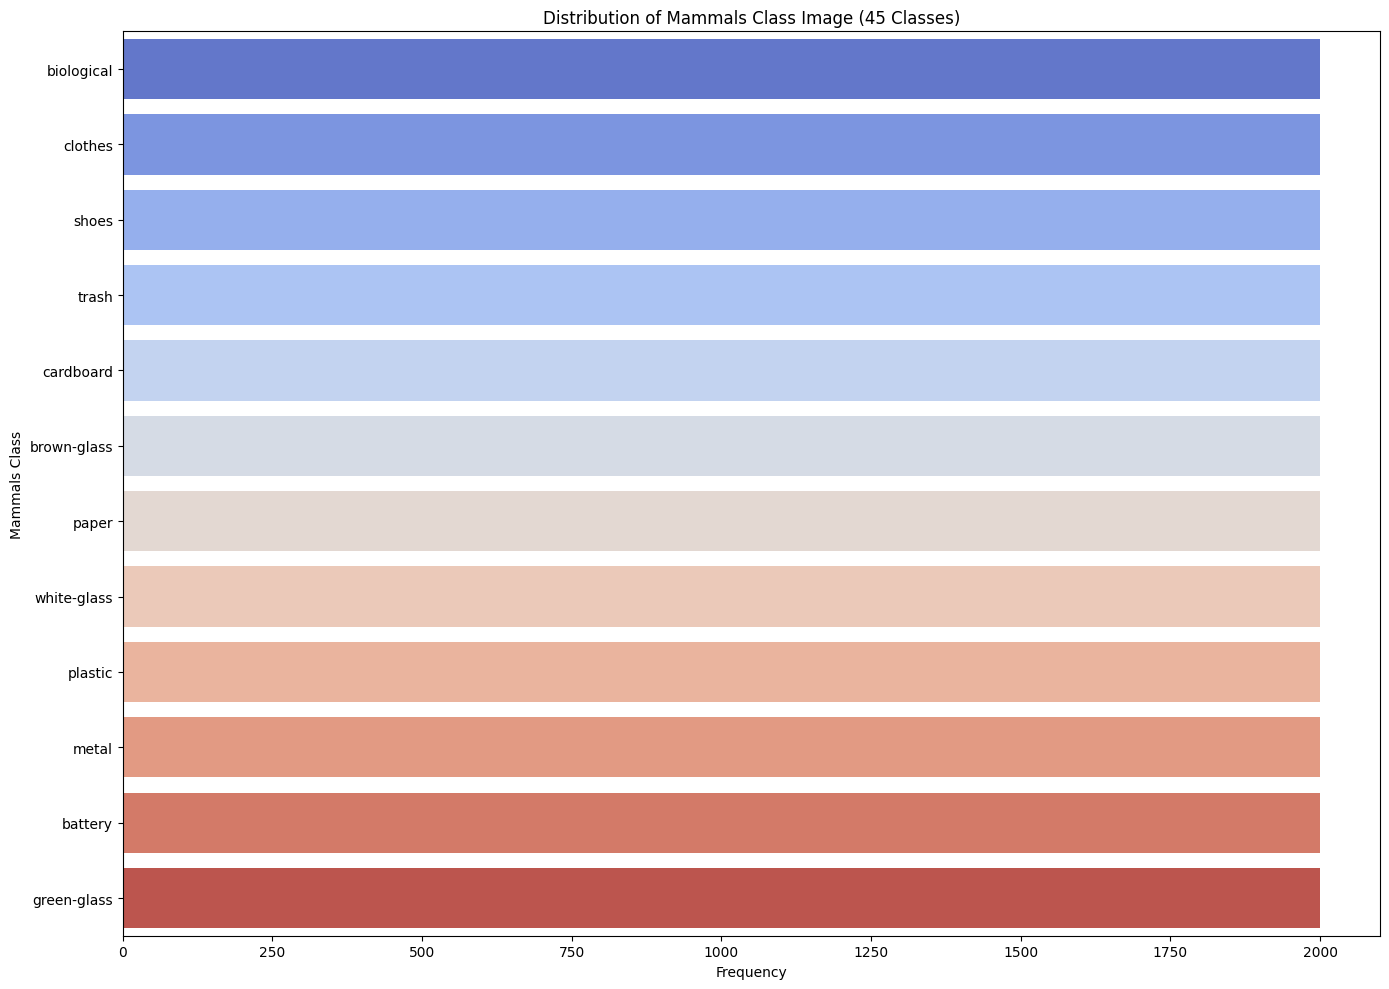

In [16]:
# Hitung jumlah gambar per kelas
class_counts = {}
for class_name in os.listdir(path):
    class_dir = os.path.join(path, class_name)
    if os.path.isdir(class_dir):
        count = len([
            file for file in os.listdir(class_dir)
            if file.lower().endswith(('.jpg'))
        ])
        class_counts[class_name] = count

# Sort berdasarkan jumlah gambar
sorted_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

# Plot
plt.figure(figsize=(14, 10))
sns.barplot(
    x=list(sorted_counts.values()),
    y=list(sorted_counts.keys()),
    palette='coolwarm',
    hue=list(sorted_counts.keys())
)
plt.xlabel("Frequency")
plt.ylabel("Mammals Class")
plt.title("Distribution of Mammals Class Image (45 Classes)")
plt.tight_layout()
plt.show()


**Note**:
- Setelah proses undersampling, jumlah data dari kelas clothes menjadi 2000 data, jumlah seimbang dengan kelas lainnya. Undersampling juga dilakukan pada kelas shoes.
- Setelah augmentasi, 10 kelas selain dari clothes memiliki jumlah data yang seimbang dengan masing-masing kelas 2000 gambar.

### **2.2 Data Split Train, Validation & Test**

In [17]:
def split_dataset(base_path, output_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    random.seed(seed)

    # Dapatkan semua folder kelas
    class_names = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

    # Untuk setiap kelas
    for class_name in tq(class_names, desc="Splitting classes"):
        class_path = os.path.join(base_path, class_name)
        images = os.listdir(class_path)
        images = [img for img in images if img.endswith(('jpg'))]

        # Acak gambar
        random.shuffle(images)

        n_total = len(images)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)
        n_test = n_total - n_train - n_val  # Sisanya test

        # Paths tujuan
        train_dir = os.path.join(output_path, 'train', class_name)
        val_dir = os.path.join(output_path, 'val', class_name)
        test_dir = os.path.join(output_path, 'test', class_name)

        # Buat foldernya kalau belum ada
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        # Copy file
        for i, img_name in enumerate(images):
            src = os.path.join(class_path, img_name)
            if i < n_train:
                dst = os.path.join(train_dir, img_name)
            elif i < n_train + n_val:
                dst = os.path.join(val_dir, img_name)
            else:
                dst = os.path.join(test_dir, img_name)
            shutil.copy(src, dst)

    print("Proses selesai")

In [18]:
base_path = '/content/garbage_classification'
output_path = '/content/garbage_classification_split'
split_dataset(base_path, output_path)

Splitting classes:   0%|          | 0/12 [00:00<?, ?it/s]

Proses selesai


In [19]:
def count_images_per_class(directory):
    class_counts = defaultdict(int)
    total = 0

    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            num_images = len([file for file in os.listdir(class_path) if file.endswith(('.jpg'))])
            class_counts[class_folder] = num_images
            total += num_images
    return total, dict(class_counts)

base_path = '/content/garbage_classification_split'

train_dir = os.path.join(base_path, 'train')
val_dir = os.path.join(base_path, 'val')
test_dir = os.path.join(base_path, 'test')

# Hitung
train_total, train_class_counts = count_images_per_class(train_dir)
val_total, val_class_counts = count_images_per_class(val_dir)
test_total, test_class_counts = count_images_per_class(test_dir)

# Print hasil
print(f"Train total images: {train_total}")
for cls, count in train_class_counts.items():
    print(f"  {cls}: {count}")

print(f"\nValidation total images: {val_total}")
for cls, count in val_class_counts.items():
    print(f"  {cls}: {count}")

print(f"\nTest total images: {test_total}")
for cls, count in test_class_counts.items():
    print(f"  {cls}: {count}")

print(f"\nTotal images in dataset: {train_total + val_total + test_total}")


Train total images: 16800
  biological: 1400
  clothes: 1400
  shoes: 1400
  trash: 1400
  cardboard: 1400
  brown-glass: 1400
  paper: 1400
  white-glass: 1400
  plastic: 1400
  metal: 1400
  battery: 1400
  green-glass: 1400

Validation total images: 3600
  biological: 300
  clothes: 300
  shoes: 300
  trash: 300
  cardboard: 300
  brown-glass: 300
  paper: 300
  white-glass: 300
  plastic: 300
  metal: 300
  battery: 300
  green-glass: 300

Test total images: 3600
  biological: 300
  clothes: 300
  shoes: 300
  trash: 300
  cardboard: 300
  brown-glass: 300
  paper: 300
  white-glass: 300
  plastic: 300
  metal: 300
  battery: 300
  green-glass: 300

Total images in dataset: 24000


**Note**:
- Dataset terbagi menjadi train, val dan test dengan rasio 0.70, 0.15 dan 0.15. Untuk data train dan val adalah data yang digunakan untuk proses latih. Sedangkan data test digunakan saat menguji model nantinya.

### **2.3 Image Data Generator**

In [20]:
base_dir = '/content/garbage_classification_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [21]:
datagen = ImageDataGenerator(
    rescale=1./255.
)

test_datagen = ImageDataGenerator(
    rescale=1./255.
)

train_generator = datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size=1,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

Found 16800 images belonging to 12 classes.
Found 3600 images belonging to 12 classes.
Found 3600 images belonging to 12 classes.


## **3. Modelling**

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(12, activation='softmax'))

print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,860 (1.61 MB)

 Trainable params: 422,860 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

None


In [23]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# buat threshold latih
class StopAt95Accuracy(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        train_acc = logs.get('accuracy')

        if val_acc is not None and val_acc >= 0.95:
            if train_acc is not None and train_acc >= 0.95:
                print("\nVal accuracy dan Train accuracy sudah 95%. Berhenti pelatihan.")
                self.model.stop_training = True

early_stopping = EarlyStopping(
    monitor='accuracy',
    patience=5,
    verbose=1,
    min_delta=0.005,
    mode='max'
)

callbacks = [
    early_stopping,
    StopAt95Accuracy()
]

**Note**:
- Proses latih menggunakan callback earlystopping dengan ketentuan jika mencapai val_accuracy dan accuracy 95% maka model terhenti.
- Namun, jika model nantinya mencapai nilai min_delta=0.005 lebih dahulu karena tidak adanya peningkatan pada latih, maka model akan berhenti berlatih.
- Jadi selama proses mencapai akurasi yang diinginkan bisa saja tidak mencapai nilai tersebut karena terfilter nilai min_delta tadi.

In [25]:
# Latih model dengan callback
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


525/525 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - accuracy: 0.2080 - loss: 2.2180 - val_accuracy: 0.4436 - val_loss: 1.6674
Epoch 2/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.4290 - loss: 1.6787 - val_accuracy: 0.5067 - val_loss: 1.4870
Epoch 3/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - accuracy: 0.4813 - loss: 1.5328 - val_accuracy: 0.5300 - val_loss: 1.4369
Epoch 4/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - accuracy: 0.5223 - loss: 1.4475 - val_accuracy: 0.5242 - val_loss: 1.4429
Epoch 5/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - accuracy: 0.5410 - loss: 1.3836 - val_accuracy: 0.5736 - val_loss: 1.2928
Epoch 6/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - accuracy: 0.5698 - loss: 1.3065 - val_accuracy: 0.6003 - val_loss: 1.1857
Epoch 7/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step - accuracy: 0.5951 - loss: 1.2292 - val_accuracy: 0.6306 - val_loss: 1.0989
Epoch 8/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - accuracy: 0.6126 - loss: 1.1820 - val_

**Note**:
- Meskipun model tidak mencapai target akurasi yang diharapkan, model yang dihasilkan tetap tergolong model yang baik, dengan capaian akurasi sebesar 93% pada data pelatihan dan 88% pada data validasi.

- Hal ini terjadi karena dalam 5 epoch terakhir, akurasinya stagnan (tidak mengalami peningkatan signifikan), sehingga callback EarlyStopping menghentikan proses pelatihan lebih awal sesuai dengan ketentuan min_delta=0.005.

## **4. Evaluasi dan Visualisasi**

In [29]:
# evaluasi model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

3600/3600 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9082 - loss: 0.3956
Test Loss: 0.4700
Test Accuracy: 0.8861


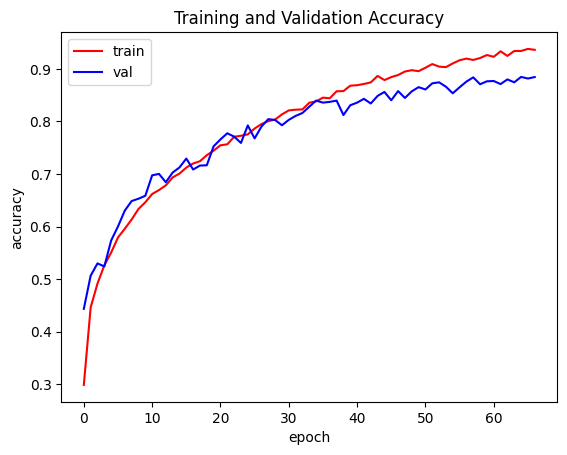

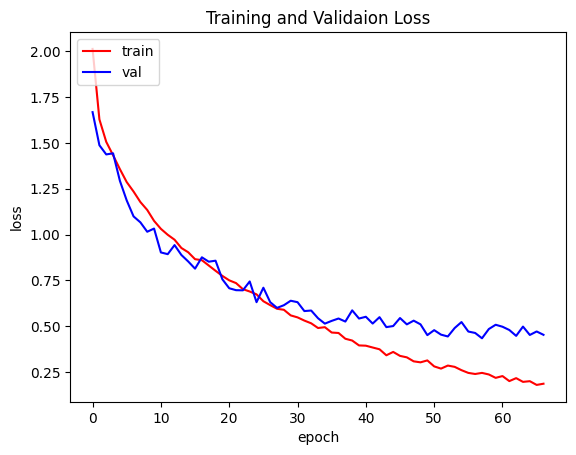

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## **5.Konversi Model**

### **5.1 SavedModel**

In [31]:
save_path = '/content/saved_model'
tf.saved_model.save(model, save_path)

### **5.2 TFLite Model**

In [32]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')
tflite_model = converter.convert()

with tf.io.gfile.GFile('garbage_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [33]:
with open('label.txt', 'w') as f:
    for class_name in class_names:
        # Menyaring hanya folder yang valid (mengabaikan file)
        if os.path.isdir(os.path.join(path, class_name)):
            f.write(class_name + '\n')

print("File 'label.txt' telah dibuat.")

File 'label.txt' telah dibuat.


In [34]:
!mkdir /content/tflite
!mv /content/garbage_classification_model.tflite /content/tflite/
!mv /content/label.txt /content/tflite/

### **5.3 TFJS Model**

In [35]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/saved_model/ \
    /content/tfjs_model

2025-04-30 05:27:54.579787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745990874.602443   14361 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745990874.608826   14361 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-30 05:27:59.476547: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745990879.476712   14361 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [36]:
# jadikan semua file dalam zip untuk diunduh, persiapan submission
!zip -r /content/saved_model.zip /content/saved_model
!zip -r /content/tfjs_model.zip /content/tfjs_model
!zip -r /content/tflite.zip /content/tflite

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/assets/ (stored 0%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.index (deflated 64%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/saved_model/saved_model.pb (deflated 87%)
  adding: content/saved_model/fingerprint.pb (stored 0%)
  adding: content/tfjs_model/ (stored 0%)
  adding: content/tfjs_model/group1-shard1of1.bin (deflated 7%)
  adding: content/tfjs_model/model.json (deflated 89%)
  adding: content/tflite/ (stored 0%)
  adding: content/tflite/garbage_classification_model.tflite (deflated 74%)
  adding: content/tflite/label.txt (deflated 26%)


In [37]:
# buat file requirements.txt
!pip freeze > requirements.txt

## **6. Inference Test**

Saving baterai_uji.jpg to baterai_uji.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


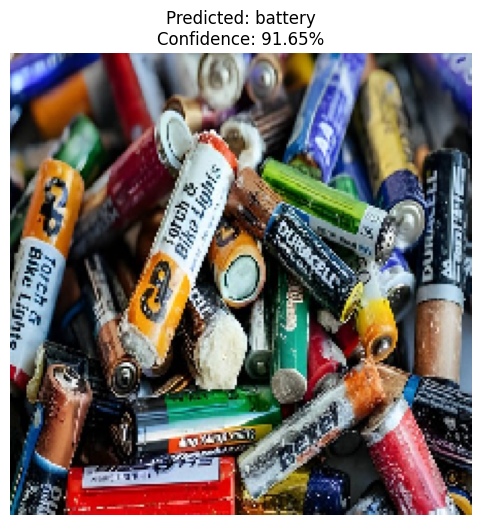

In [44]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    test_img = image.load_img(fn, target_size=(224, 224), color_mode='rgb')

    # preprocessing gambar
    pp_test_img = image.img_to_array(test_img)
    pp_test_img = pp_test_img / 255
    pp_test_img = np.expand_dims(pp_test_img, axis=0)

    # prediksi
    test_preds = model.predict(pp_test_img)

    # cetak hasil prediksi
    predicted_class_idx = np.argmax(test_preds, axis=1)[0]
    predicted_class = class_names[predicted_class_idx]
    predicted_prob = test_preds[0][predicted_class_idx]

    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}\nConfidence: {predicted_prob*100:.2f}%")
    plt.imshow(test_img)
    plt.show()